In [1]:
#As we dont have any GPU we will be using google collab for GPU usage
#Mout at drive 
import sys
from google.colab import drive
from pathlib import Path
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
#needed packages to install
#!pip install texthero==1.0.5
#!pip install gensim
#!pip install openpyxl 
#!pip install bnlp_toolkit
#!pip install python-bidi
#!pip install texthero
#!pip install bangla-stemmer

In [3]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud
from bnlp.corpus import stopwords, punctuations
import bnlp
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from bnlp import BasicTokenizer,NLTKTokenizer
from bangla_stemmer.stemmer.stemmer import BanglaStemmer
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/dataset/multi class bangla social media comment.xlsx')
df.to_csv('/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/dataset/multi_class_bangla_social_media_comment.csv', encoding='utf-8', index=False)
df.head()

,comment,Category,Gender,comment react number,label
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,Actor,Female,1.0,sexual
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,Singer,Male,2.0,not bully
2,"অরে বাবা, এই টা কোন পাগল????",Actor,Female,2.0,not bully
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully
4,পটকা মাছ,Politician,Male,0.0,troll


In [5]:
df = df.rename(columns={'comment react number': 'comment_react_number'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44001 entries, 0 to 44000
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   comment               44001 non-null  object 
 1   Category              44001 non-null  object 
 2   Gender                44001 non-null  object 
 3   comment_react_number  43998 non-null  float64
 4   label                 44001 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.7+ MB


In [6]:
Category_counts=df.Category.value_counts()
Gender_counts=df.Gender.value_counts()
Comment_react_counts=df.comment_react_number.value_counts()
label_counts=df.label.value_counts()
print(Category_counts)
print("\n",Gender_counts)
print("\n",Comment_react_counts)
print("\n",label_counts)




Actor         26951
Social         9375
Singer         2981
Politician     2633
Sports         2061
Name: Category, dtype: int64

 Female    29950
Male      14051
Name: Gender, dtype: int64

 0.0      28725
1.0       8193
2.0       2955
3.0       1326
4.0        711
         ...  
60.0         1
67.0         1
132.0        1
149.0        1
284.0        1
Name: comment_react_number, Length: 114, dtype: int64

 not bully    15340
troll        10462
sexual        8928
religious     7577
threat        1694
Name: label, dtype: int64


In [7]:
def clean(text):
    text = re.sub('[%s]' % re.escape(punctuations), ' ', text)     #escape punctuation
    text = re.sub('\n', ' ', text)                                 #replace line break with space
    text = re.sub('\w*\d\w*', ' ', text)                           #ignore digits
    text = re.sub('\xa0', ' ', text)                              
    return text

def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[\u09E6-\u09FF]+', ' ', text)                  #remove bangla punctuations
    return text




In [8]:
df['text'] = df['comment'].apply(lambda x: re.split('http:\/\/.*', str(x))) #remove urls
df["text"] = df['text'].apply(lambda x: clean(str(x)))                      
df['text'] = df['text'].apply(lambda x: remove_punct(x))

In [9]:
#remove special characters
spec_chars = ["!",'"',"।","#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    df['text'] = df['text'].str.replace(char, ' ') 
    df['text'] = df['text'].str.split().str.join(' ')         #remove whitespace


In [10]:
#checking......
df.text[2226]

'বেকুবের দল বুঝেই নাই যে সাফা কবিরকে তারা ভাইরাল করে অারো বেশী পরিচিত করেছে যারা চিনতো না এখন তারাও চিনে সাফা কবির নামে একজন অভিনয় করে সাফা নাকি বেশ মজা পাচ্ছে বিষয়টা নিয়ে'

In [11]:


custom_stop_word_list=['আমার ','অথচ ','অথবা ','অনুযায়ী ','অনেক ','অনেকে ','অনেকেই ','অন্তত ','অন্য ','অবধি ','অবশ্য ','অর্থাত ','আই ','আগামী ','আগে ','আগেই ','আছে ','আজ ','আদ্যভাগে ',
                       'আপনার ','আপনারা ','আপনি ','আবার ','আসবে ','আমরা ',' আমাকে ','আমাদের ','আমার ','আমি ','আর ','আরও ','ইত্যাদি ','ইহা ','উচিত ','উত্তর ','উনি ','উপর ','উপরে ','এ ','এঁদের ','এঁরা ','এরা ',
                       'এই ','একই ','একটি ','একবার ','একে ','এক্ ','এখন ','এখনও ','এখানে ','এখানেই ','এটা ','এটাই ','এটি ','এত ','এতটাই ','এতে ','এদের ','এব ','এবং ','এবার ','এমন ','এমনকী ',
                       'এমনি ','এর ','এরা ','এল ','এস ','এসে ','ঐ ','ওঁদের ','ওঁর ','ওঁরা ','ওই ','ওকে ','ওখানে ','ওদের ','ওর ','ওরা ','কখনও ','কত ','কবে ','কমনে ','কয়েক ','কয়েকটি ','করছে ',
                       'করছেন ','করতে ',' করবে',' করবেন',' করলে ',' করলেন',' করা',' করাই',' করায়',' করার',' করি','করতে ','করিতে ','করিয়া ','করিয়ে ','করে ','করেই ','করেছিলেন ','করেছে ','করেছেন ','করেন ',
                       'কাউকে ','কাছ ','কাছে ','কাজ ','কাজে ','কারও ','কারণ ','কি ','কিংবা ','কিছু ','কিছুই ','হেতি ','কিন্তু ','ন্তু ','কী ','কে ','কেউ ','কেউই ','কেখা ','কেন ','কোটি ','কোন ','কোনও ',
                       'কোনো ','ক্ষেত্রে ','কয়েক ','খুব ','গিয়ে ','গিয়েছে ','গেছেন ','গিয়ে ','গুলি ','গেছে ','গেল ','গেলে ','গোটা ','চলে ','চান ','চায় ','চার ','চালু ','চেয়ে ','চেষ্টা ','ছাড়া ','ছাড়াও ','ছিল ','ছিলেন ','জন ',
                       'জনকে ','জনের ','জন্য ','জন্যওজে ','জানতে ','জানা ','জানানো ','জানায় ','জানিয়ে ','জানিয়েছে ','জ্নজন ','জন ','টা ','টি ','ঠিক ','তখন ','তত ','তথা ','তবু ','তবে ','তা ','তাঁকে ','তাঁদের ',
                       'তাঁর ','তোর ','তাঁরা ','তাঁাহারা ','তাই ','যে ''তাও ','তাকে ','তাতে ','তাদের ','তার ','তারপর ','তারা ','তারৈ ','তাহলে ','তাহা ','তাহাতে ' ,'তাহার ','তিনঐ ','তিনি ','তিনিও ','তুমি ','তুলে ','তেমন ','তো ','তোমার ',
                       'থাকবে ','থাকবেন ','থাকা ','থাকায় ','থাকে ','থাকেন ','থেকে ','থেকেই ','থেকেও ','দিকে ','দিতে ','দিন ','দিয়ে ','দিয়েছে ','দিয়েছেন ','দিলেন ', 'দু ','দুই ','দুটি ','দুটো ','দেওয়া ','দেওয়ার ','দেওয়া ',
                       'দেখতে ','দেখা ','দেখে ','দেন ','দেয়া ','দেয় ','দ্বারা ','ধরা ','ধরে ','ধামার ','নতুন ','নাই ','নাকি ','নাগাদ ','নানা ','নিজে ','নিজেই ','নিজেদের ','নিজের ','নিতে ','নিয়ে ','নিয়ে ','নেই ','নেওয়া ','নেওয়ার ',
                       'নেওয়া ','নয় ','পক্ষে ','পর ','পরে ','পরেই ','পরেও ','পর্যন্ত ','পাওয়া ','পাচ ','পারি ','পারে ','পারেন ','পেয়ে ','পেয়্র্ ','প্রতি ','প্রথম ','প্রভৃতি ','প্রযন্ত ','প্রাথমিক ','প্রায় ','প্রায় ','ফলে ','ফিরে ','ফের ',
                       'বক্তব্য ','বদলে ','বন ','বরং ','বলতে ','বলছি ','বলল ','বললেন ','বলা ','বলে ','বলেছেন ','বলেন ','বসে ','বহু' ,'বাদে ','বার ','বিনা ','বিভিন্ন ','বিশেষ ','বিষয়টি ','বেশ ','বেশি ','ব্যবহার ','ব্যাপারে ','ভাবে ', 'ভাবেই ',
                       'মতো ','মতোই ','মধ্যভাগে ','মধ্যে ','মধ্যেই ','মধ্যেও ','মনে ','মাত্র ','মাধ্যমে ','মোট ','মোটেই ','যখন ','যত ','যতটা ','যথেষ্ট ','যদি ','যদিও ','যা ','যাঁর ','যাঁরা ','যাওয়া ','যাওয়ার ','যাওয়া ','যাকে ','যাচ্ছে ',
                       'যাতে ','যাদের ','যান ','যাবে ','যায় ','যার ','যারা ','যিনি ','অতএব ','যেখানে ','যেতে ','যেন ','যেমন ','রকম ','রয়েছে ','রাখা ','রেখে ','লক্ষ ','শুধু ','শুরু ','সঙ্গে ','সঙ্গেও ','সব ','সবার ','সবাইর ','সমস্ত ',
                       'সম্প্রতি ','সহ ','সহিত ','সবই ','সাধারণ ','সামনে ','সুতরাং ','সবাইর ','সে ','সেই ','সেখান ','সেখানে ','সেটা ', 'সেটাই ','সেটাও ','সেটি ','স্পষ্ট ','স্বয়ং ','হইতে ','হইবে ','হইয়া ','হওয়া ','হওয়ায় ','হওয়ার ','হচ্ছে ','হত ','হতে ',
                       'লেগেছে ','হতেই ','হন ','হইত ','হবে ','তিনি ','হবেন ','হয় ','হয়তো ','হয়নি ','হয়ে ','হয়েই ','হয়েছিল ','হয়েছে ','হয়েছেন ','হল ','হলে ','হলেই ','হলেও ','হলো ','হাজার ','হিসাবে ','হৈলে ','হোক ','হয় ']

#digits=['০ ','১ ','২ ','৩ ','৪ ','৫ ','৬ ','৭ ','৮ ','৯ ']

final_stopword_list = custom_stop_word_list 

pat = r'\b(?:{})\b'.format('|'.join(final_stopword_list))
df['text'] = df['text'].str.replace(pat, ' ')
df['text'] = df['text'].str.replace(r'\s+', ' ')


In [12]:
#checking......
df.text[2226]

'বেকুবের দল বুঝেই যে সাফা কবিরকে ভাইরাল অারো বেশী পরিচিত চিনতো না তারাও চিনে সাফা কবির নামে একজন অভি সাফা মজা পাচ্ছে বিষয়টা নিয়ে'

(-0.5, 399.5, 199.5, -0.5)

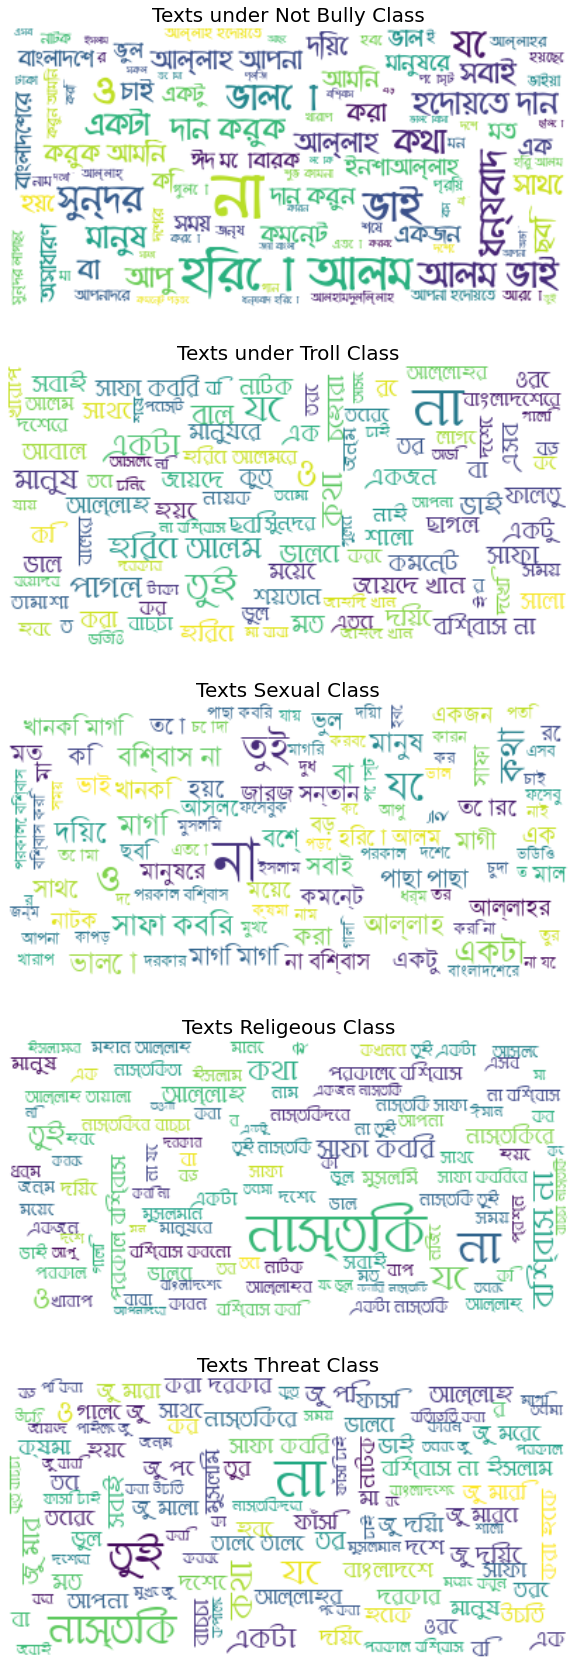

In [13]:
regex = r"[\u0980-\u09FF]+"

# Start with one review:
df_NB = df[df['label']=="not bully"]
df_TR = df[df['label']=="troll"]
df_SE = df[df['label']=="sexual"]
df_RE = df[df['label']=="religious"]
df_TH = df[df['label']=="threat"]

text_NB = " ".join(review for review in df_NB.text)
text_TR = " ".join(review for review in df_TR.text)
text_SE = " ".join(review for review in df_SE.text)
text_RE = " ".join(review for review in df_RE.text)
text_TH = " ".join(review for review in df_TH.text)

fig, ax = plt.subplots(5, 1, figsize  = (30,30))
# Create and generate a word cloud image:
wordcloud_NB = WordCloud(font_path="/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/BenSenHandwriting.ttf",max_font_size=50,max_words=100,regexp=regex, background_color="white").generate(text_NB)
wordcloud_TR = WordCloud(font_path="/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/MOHAO___.ttf",max_font_size=50,max_words=100,regexp=regex, background_color="white").generate(text_TR)
wordcloud_SE = WordCloud(font_path="/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/NikoshLight.ttf",max_font_size=50,max_words=100,regexp=regex, background_color="white").generate(text_SE)
wordcloud_RE = WordCloud(font_path="/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/MOHAO___.ttf",max_font_size=50,max_words=100,regexp=regex, background_color="white").generate(text_RE)
wordcloud_TH = WordCloud(font_path="/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/MOHAO___.ttf",max_font_size=50,max_words=100,regexp=regex, background_color="white").generate(text_TH)


# Display the generated image:
ax[0].imshow(wordcloud_NB, interpolation='bilinear')
ax[0].set_title('Texts under Not Bully Class',fontsize=20)
ax[0].axis('off')
ax[1].imshow(wordcloud_TR, interpolation='bilinear')
ax[1].set_title('Texts under Troll Class',fontsize=20)
ax[1].axis('off')
ax[2].imshow(wordcloud_SE, interpolation='bilinear')
ax[2].set_title('Texts Sexual Class',fontsize=20)
ax[2].axis('off')
ax[3].imshow(wordcloud_RE, interpolation='bilinear')
ax[3].set_title('Texts Religeous Class',fontsize=20)
ax[3].axis('off')
ax[4].imshow(wordcloud_TH, interpolation='bilinear')
ax[4].set_title('Texts Threat Class',fontsize=20)
ax[4].axis('off')

In [14]:
b_token = BasicTokenizer()
df['tokenized_text'] = df.apply(lambda row: b_token.tokenize(row['text']), axis=1)

df['token_length'] = df.apply(lambda row: len(row['tokenized_text']), axis=1)

df.head() 

,comment,Category,Gender,comment_react_number,label,text,tokenized_text,token_length
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,Actor,Female,1.0,sexual,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দ...,"[হালার, পুত, মদ, খাওয়ার, সময়, রাতের, বেলা, ম...",26
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,Singer,Male,2.0,not bully,ঘরে শুট কেমন ক্যামেরাতে ছিলেন,"[ঘরে, শুট, কেমন, ক্যামেরাতে, ছিলেন]",5
2,"অরে বাবা, এই টা কোন পাগল????",Actor,Female,2.0,not bully,অরে বাবা পাগল,"[অরে, বাবা, পাগল]",3
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully,ক্যাপ্টেন অফ বাংলাদেশ,"[ক্যাপ্টেন, অফ, বাংলাদেশ]",3
4,পটকা মাছ,Politician,Male,0.0,troll,পটকা মাছ,"[পটকা, মাছ]",2


In [15]:
def lemmatize_text(text):
    stm = BanglaStemmer()
    return [stm.stem(w) for w in text]
df['text_stem'] = df["tokenized_text"].apply(lemmatize_text)
df.head() 


Streaming output truncated to the last 5000 lines.
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied fourth rules..
applied third rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied second rules..
a

,comment,Category,Gender,comment_react_number,label,text,tokenized_text,token_length,text_stem
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,Actor,Female,1.0,sexual,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দ...,"[হালার, পুত, মদ, খাওয়ার, সময়, রাতের, বেলা, ম...",26,"[হালা, পুত, মদ, খাওয়, সময়, রাত, বেলা, মদ, খা..."
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,Singer,Male,2.0,not bully,ঘরে শুট কেমন ক্যামেরাতে ছিলেন,"[ঘরে, শুট, কেমন, ক্যামেরাতে, ছিলেন]",5,"[ঘরে, শুট, কেমন, ক্যামেরা, ছিল]"
2,"অরে বাবা, এই টা কোন পাগল????",Actor,Female,2.0,not bully,অরে বাবা পাগল,"[অরে, বাবা, পাগল]",3,"[অরে, বাবা, পাগল]"
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully,ক্যাপ্টেন অফ বাংলাদেশ,"[ক্যাপ্টেন, অফ, বাংলাদেশ]",3,"[ক্যাপ্ট, অফ, বাংলাদেশ]"
4,পটকা মাছ,Politician,Male,0.0,troll,পটকা মাছ,"[পটকা, মাছ]",2,"[পটকা, মাছ]"


In [16]:
df.describe()

,comment_react_number,token_length
count,43998.000000,44001.000000
mean,1.180849,12.425195
std,6.671492,16.763291
min,0.000000,0.000000
25%,0.000000,4.000000
50%,0.000000,7.000000
75%,1.000000,14.000000
max,428.000000,217.000000


In [17]:
df.head()

,comment,Category,Gender,comment_react_number,label,text,tokenized_text,token_length,text_stem
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,Actor,Female,1.0,sexual,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দ...,"[হালার, পুত, মদ, খাওয়ার, সময়, রাতের, বেলা, ম...",26,"[হালা, পুত, মদ, খাওয়, সময়, রাত, বেলা, মদ, খা..."
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,Singer,Male,2.0,not bully,ঘরে শুট কেমন ক্যামেরাতে ছিলেন,"[ঘরে, শুট, কেমন, ক্যামেরাতে, ছিলেন]",5,"[ঘরে, শুট, কেমন, ক্যামেরা, ছিল]"
2,"অরে বাবা, এই টা কোন পাগল????",Actor,Female,2.0,not bully,অরে বাবা পাগল,"[অরে, বাবা, পাগল]",3,"[অরে, বাবা, পাগল]"
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully,ক্যাপ্টেন অফ বাংলাদেশ,"[ক্যাপ্টেন, অফ, বাংলাদেশ]",3,"[ক্যাপ্ট, অফ, বাংলাদেশ]"
4,পটকা মাছ,Politician,Male,0.0,troll,পটকা মাছ,"[পটকা, মাছ]",2,"[পটকা, মাছ]"


In [18]:
col=['comment','comment_react_number','tokenized_text','token_length']
df1=df.drop(col,axis=1)
df1.to_csv('/content/drive/MyDrive/Colab Notebooks/multi class bangla sentiment analysis/dataset/bangla_comments_tokenized.csv', index = False, header=True)
df1.tail()

,Category,Gender,label,text,text_stem
43996,Social,Male,not bully,হিরো আলম এগিয়ে যাও,"[হিরো, আলম, এগা, যাও]"
43997,Social,Male,not bully,হিরো আলমকে সাপোর্ট অসংখ্য ধন্যবাদ আপনাকে,"[হিরো, আলম, সাপোর্ট, অসংখ্য, ধন্যবাদ, আপনা]"
43998,Social,Male,not bully,হিরো ভাই এগিয়ে য়াও,"[হিরো, ভাই, এগা, য়াও]"
43999,Actor,Female,not bully,হুম ভাও তোমরা এগিয়ে যাও তোমাদের পিছনে আছি,"[হুম, ভাও, তোমরা, এগা, যাও, তোমা, পিছনে, আছি]"
44000,Social,Male,not bully,হ্যালো তোমাদের সাথে আমা চ্যাট করবে,"[হ্যালো, তোমা, সাথে, আমা, চ্যাট, করবে]"


In [19]:
df=df[df['tokenized_text'].map(len) < 30]